## Lutfen bu linke git:
https://nbviewer.jupyter.org/github/selimonat/ornament_symmgroups/blob/master/CorrelationAnalysis.ipynb

# Import libraries

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

from sklearn.datasets import load_digits
from sklearn import manifold

from joblib import Memory
location = './cachedir'
memory = Memory(location, verbose=0)

import folium

from scipy.stats import zscore

%matplotlib notebook
import matplotlib.gridspec as gridspec

SAVEPNG = False
METRIC = True
CAPITALS = ['Granada','Yerevan','Istanbul','Cairo','Konya','Isfahan']

def remove_top_right(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax


from sklearn.metrics import euclidean_distances

def plot_mds(symm_df,ax,input_is_corr=False,xlim=None,ylim=None):
    # similarities = euclidean_distances(symm_df.T)
    if input_is_corr is False:#compute correlation if input is not correlation matrix
        similarities = 1-symm_df.astype(float).corr()
    else:
        similarities = symm_df.values
        
    # plt.matshow(similarities)
    seed = np.random.RandomState(seed=3)
    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                       dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(similarities).embedding_
    if METRIC is False:
        nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12,
                            dissimilarity="precomputed", random_state=seed, n_jobs=1,
                            n_init=1)
        pos = nmds.fit_transform(similarities, init=pos)    
    ax.plot(pos[:,0],pos[:,1],'ok',markersize=10)
    for i, txt in enumerate(symm_df.columns):
        ax.annotate(txt, (pos[i,0]+0.015,  pos[i,1]),fontsize=12)
    ax.set_ylabel('Dim2',fontsize=16)
    ax.set_xlabel('Dim1',fontsize=16)
    ax = remove_top_right(ax)
    ax.grid()
    plt.tight_layout()
    ax.set_aspect('equal')
#     ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    if xlim is not None:
        S=xlim/2.0
        Tx = np.arange(-xlim, xlim+S,step=S)
        Ty = np.arange(-ylim, ylim+S,step=S)
        ax.set_xticks(Tx)
        ax.set_yticks(Ty)
        ax.set_ylim(-ylim,ylim)
        ax.set_xlim(-xlim,xlim)
    return ax

def correlation_panel(df,ax,input_is_corr=False,TITLE='Correlation Matrix'):
    if input_is_corr is False:
        # calculate the correlation matrix    
        corr = df.corr()
    elif input_is_corr is True:
        corr = df
    # plot the heatmap
    TICKLABELS = corr.columns.str.replace(' ','\n')
    sns.heatmap(corr, 
            xticklabels=TICKLABELS,
            yticklabels=TICKLABELS,
            cmap="RdBu_r",
            square=True,
            ax=ax,
            cbar_kws={"shrink": 0.5},
            annot=corr.values)
    ax.set_title(TITLE,fontsize=16)
    ax.set_yticklabels(TICKLABELS,fontsize=12,va='center')
    ax.set_xticklabels(TICKLABELS,fontsize=12,ha='center')
    plt.tight_layout()
    if SAVEPNG:
        plt.savefig('/Users/sonat/Documents/repos/ornament_symmgroups/figure_corrmat.png',dpi=1000)
    #biraz deli bir renk oldu ama simdilik kalsin.
    
@memory.cache
def get_geo_distances(capitals):
    geolocator = Nominatim(user_agent="bla")
    Distance = np.zeros((len(capitals),len(capitals)))
    for i,c1 in enumerate(capitals):
        for j,c2 in enumerate(capitals):
            l1 = geolocator.geocode(c1)
            l2 = geolocator.geocode(c2)
            d = geodesic(l1.point, l2.point).km
            Distance[i,j] = d
    return Distance


# Import Data

In [2]:
symm_df = pd.read_excel("./symm_groups.xlsx",index_col=0)
symm_df = symm_df.iloc[:17,[0,3,2,1,4,5]]
symm_df = symm_df.astype(float)
symm_df.head(2)

dist_symm = symm_df.corr()

# Histogram of Symmetry Groups

<IPython.core.display.Javascript object>


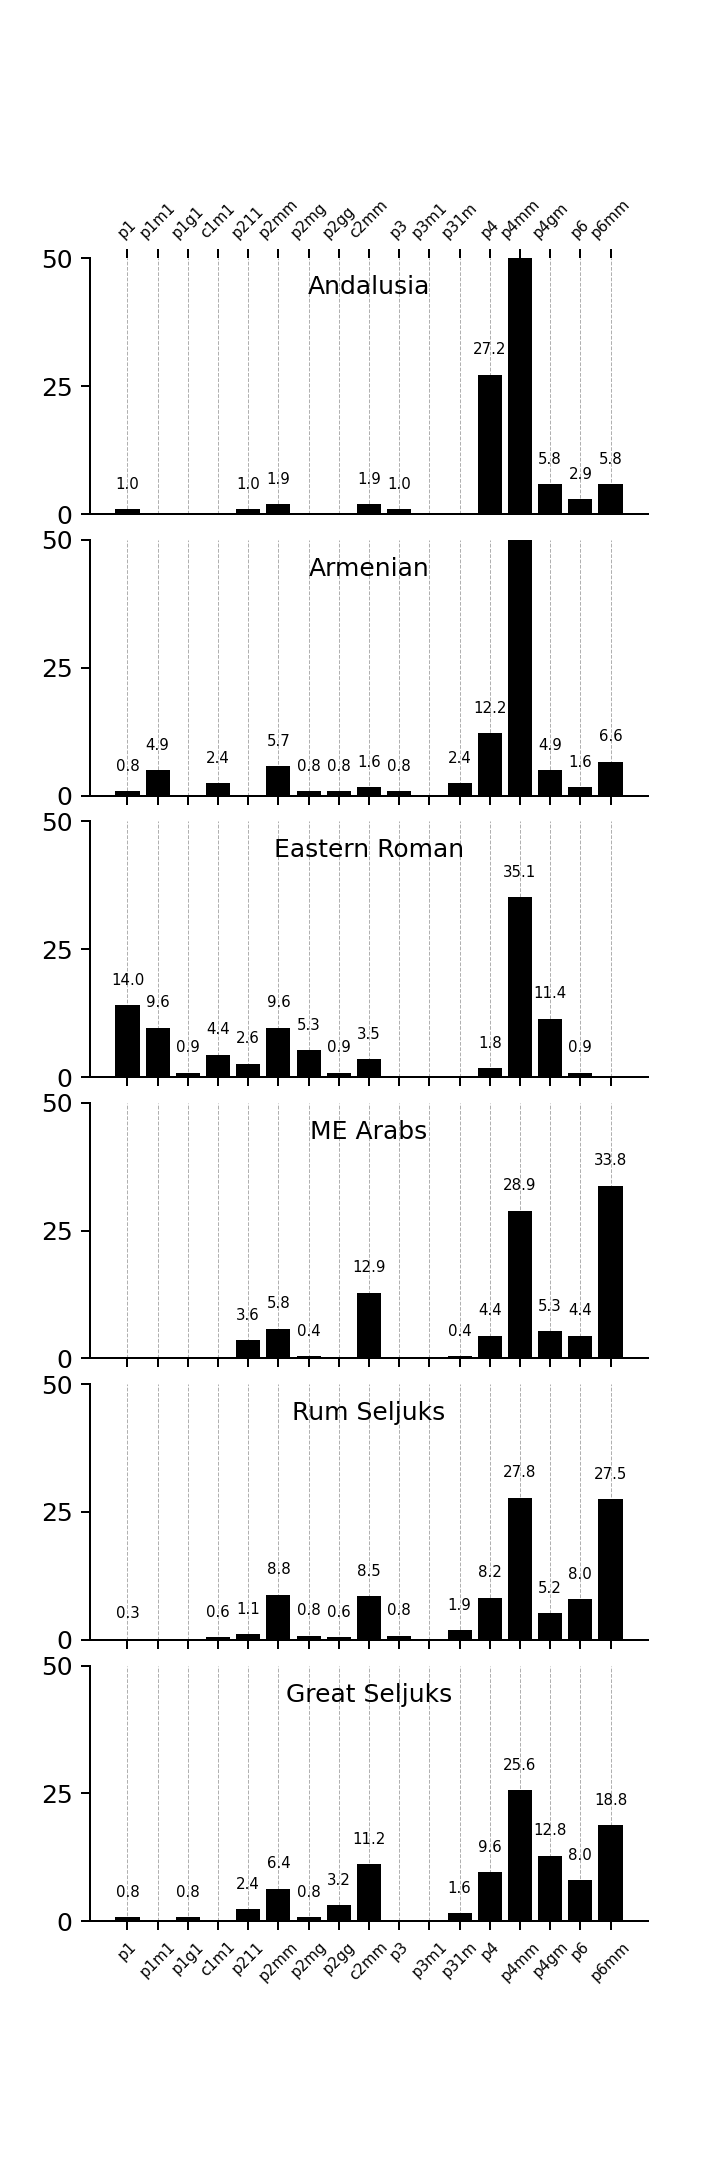

In [3]:
## FIGURE
fig = plt.figure(figsize=(4,12))
gs1 = gridspec.GridSpec(symm_df.shape[1],1)
gs1.update( hspace=0.1) # set the spacing between axes. 


cols = symm_df.columns.to_list() 
for i in [0,1,2,3,4,5]:
    ax = plt.subplot(gs1[i])
    ax.bar(range(0,17),symm_df[cols[i]],color='k')
    ax = remove_top_right(ax)
    ax.set_xticks(np.arange(symm_df.shape[0]))
    if i is 5:
        ax.set_xticklabels(symm_df.index.to_list(),rotation=45,fontsize=6,ha='center')
    elif i is 0:
        ax.set_xticklabels(symm_df.index.to_list(),rotation=45,fontsize=6,ha='center')
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top') 
    else:
        ax.set_xticklabels('')
    for p in ax.patches:
        if np.ceil(p.get_height()) != 0:
            ax.annotate(np.round(p.get_height(),decimals=1),(p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',fontsize=6)
    ax.set_title(cols[i], y=0.8, loc = 'center',fontsize=10)
    ax.set_ylim([0,50])
    ax.set_yticks([0,25,50])
    ax.grid(axis='x', linestyle='--', linewidth=.4)
    ax.set_axisbelow(True)
    
plt.subplots_adjust(hspace=.5)
# plt.savefig('/Users/sonat/Documents/repos/ornament_symmgroups/figure_histograms.png',dpi=1000)

# Correlation between Symmetry Groups

<IPython.core.display.Javascript object>


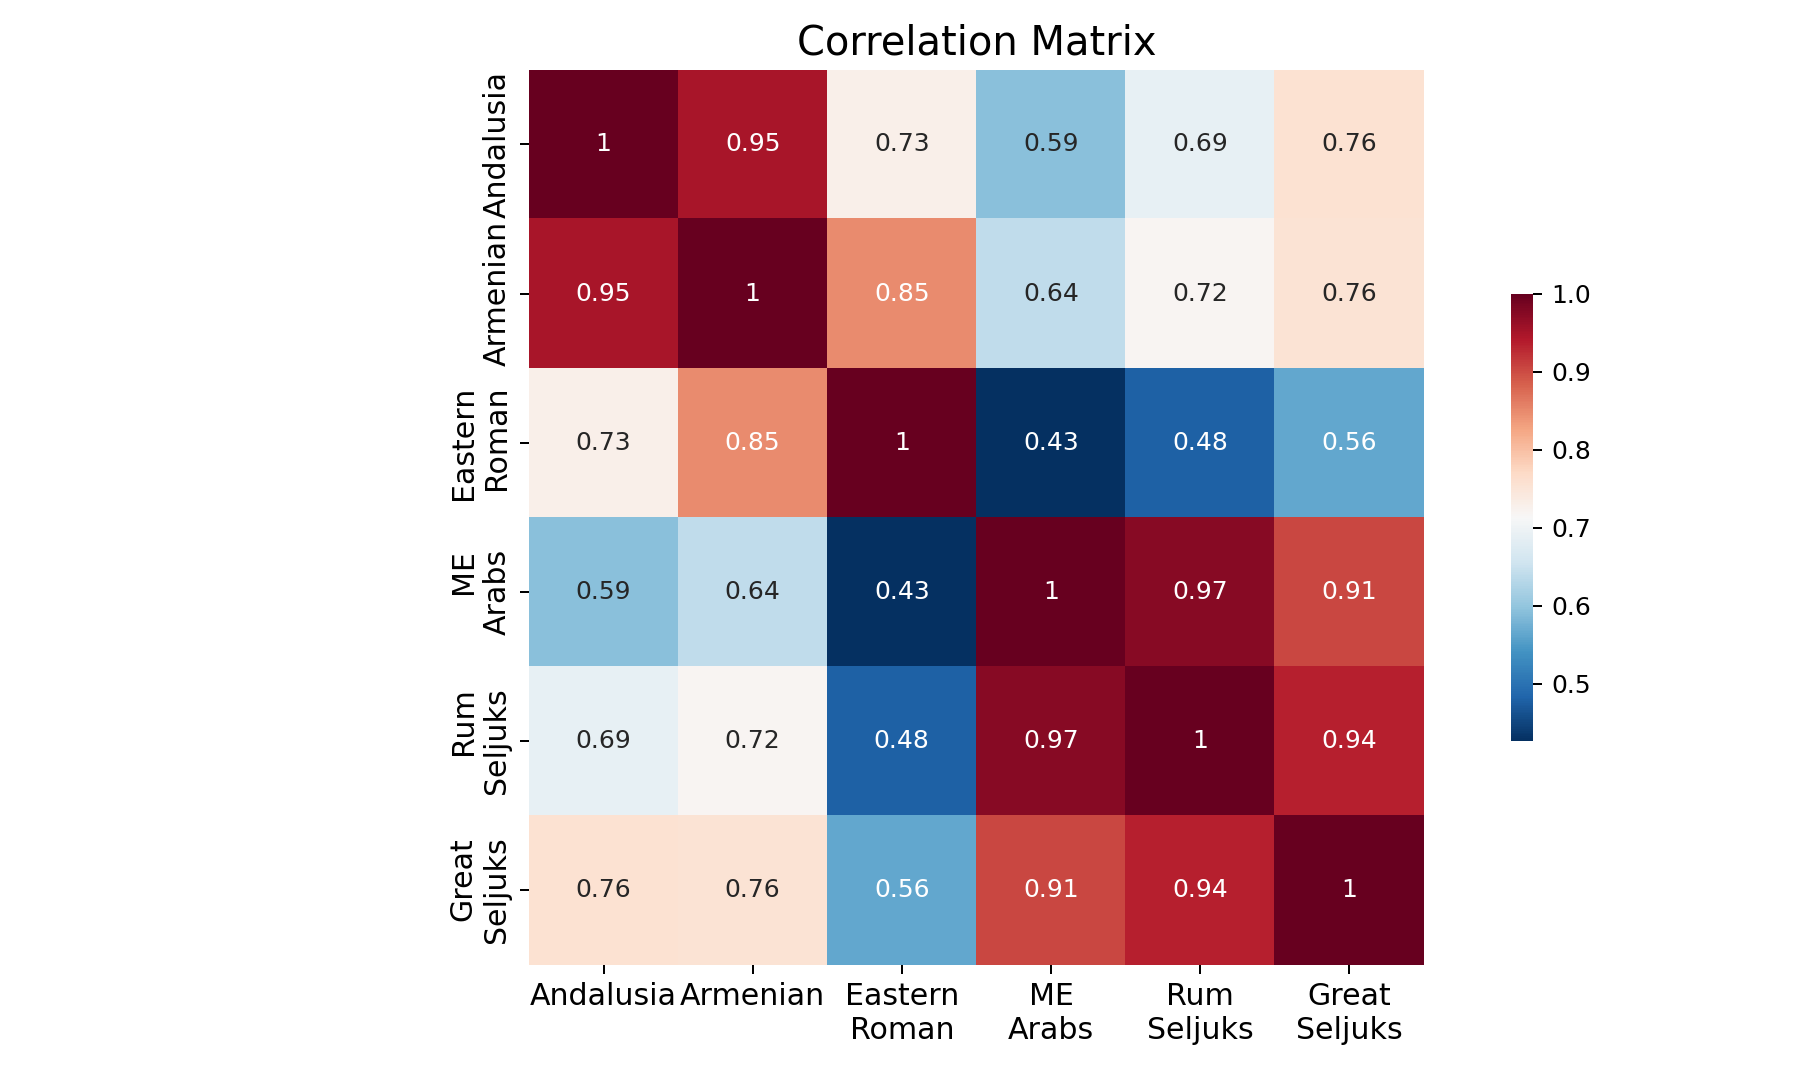

In [4]:
fig = plt.figure(figsize=(10,6))
ax  = fig.subplots(1,1)
correlation_panel(symm_df,ax=ax)

# Geographic Proximity Matrix

## Compute a geographical distance matrix akin to the correlation matrix.

In [18]:
dist_geo_full = get_geo_distances(CAPITALS)
dist_geo_full = pd.DataFrame(dist_geo_full,columns=CAPITALS,index=CAPITALS)
dist_geo = np.triu(dist_geo_full.values,1)
dist_geo = pd.DataFrame(dist_geo,columns=CAPITALS,index=CAPITALS)


fig = plt.figure(figsize=(9,6))
ax  = fig.subplots(1,1)
correlation_panel(dist_geo,ax,input_is_corr=True,TITLE='Distance Matrix (km)')

<IPython.core.display.Javascript object>

# MDS on geographical distances

## This MDS should recover coordinates of the cultural captials.

<IPython.core.display.Javascript object>


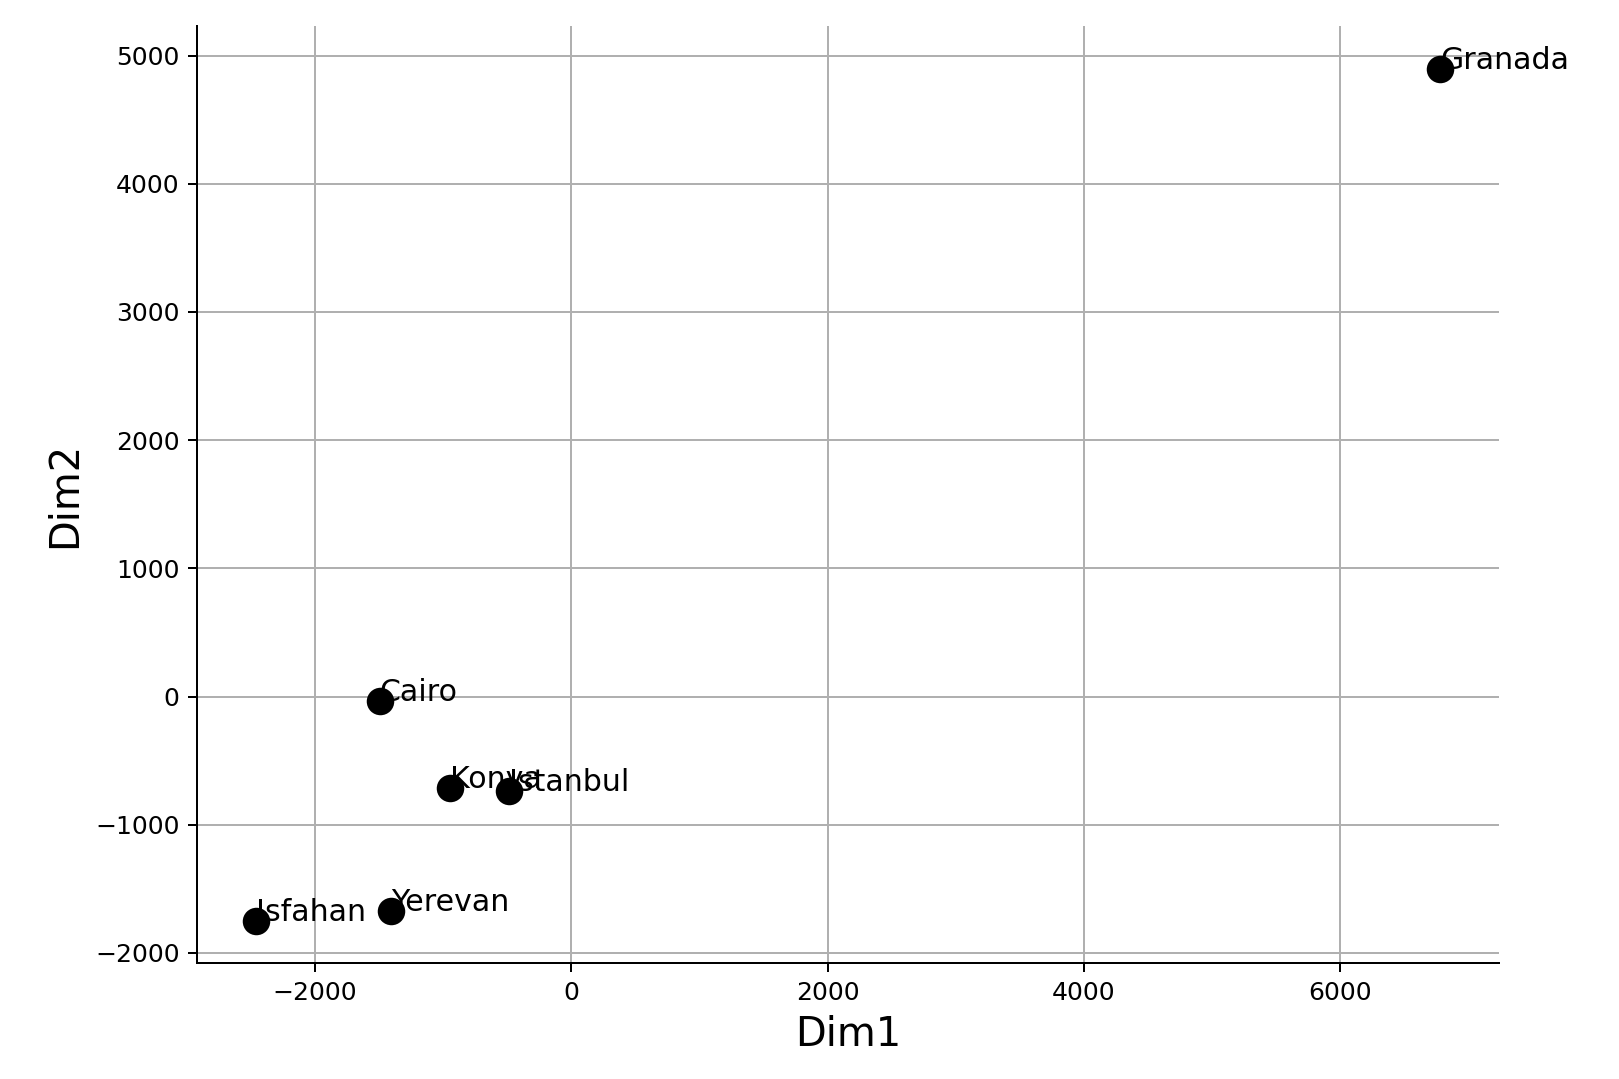

<AxesSubplot:xlabel='Dim1', ylabel='Dim2'>

In [19]:
fig = plt.figure(figsize=(9,6))
ax  = fig.subplots(1,1)
plot_mds(dist_geo_full,ax,input_is_corr=True)

# MDS on Symmetry Similarity

<IPython.core.display.Javascript object>


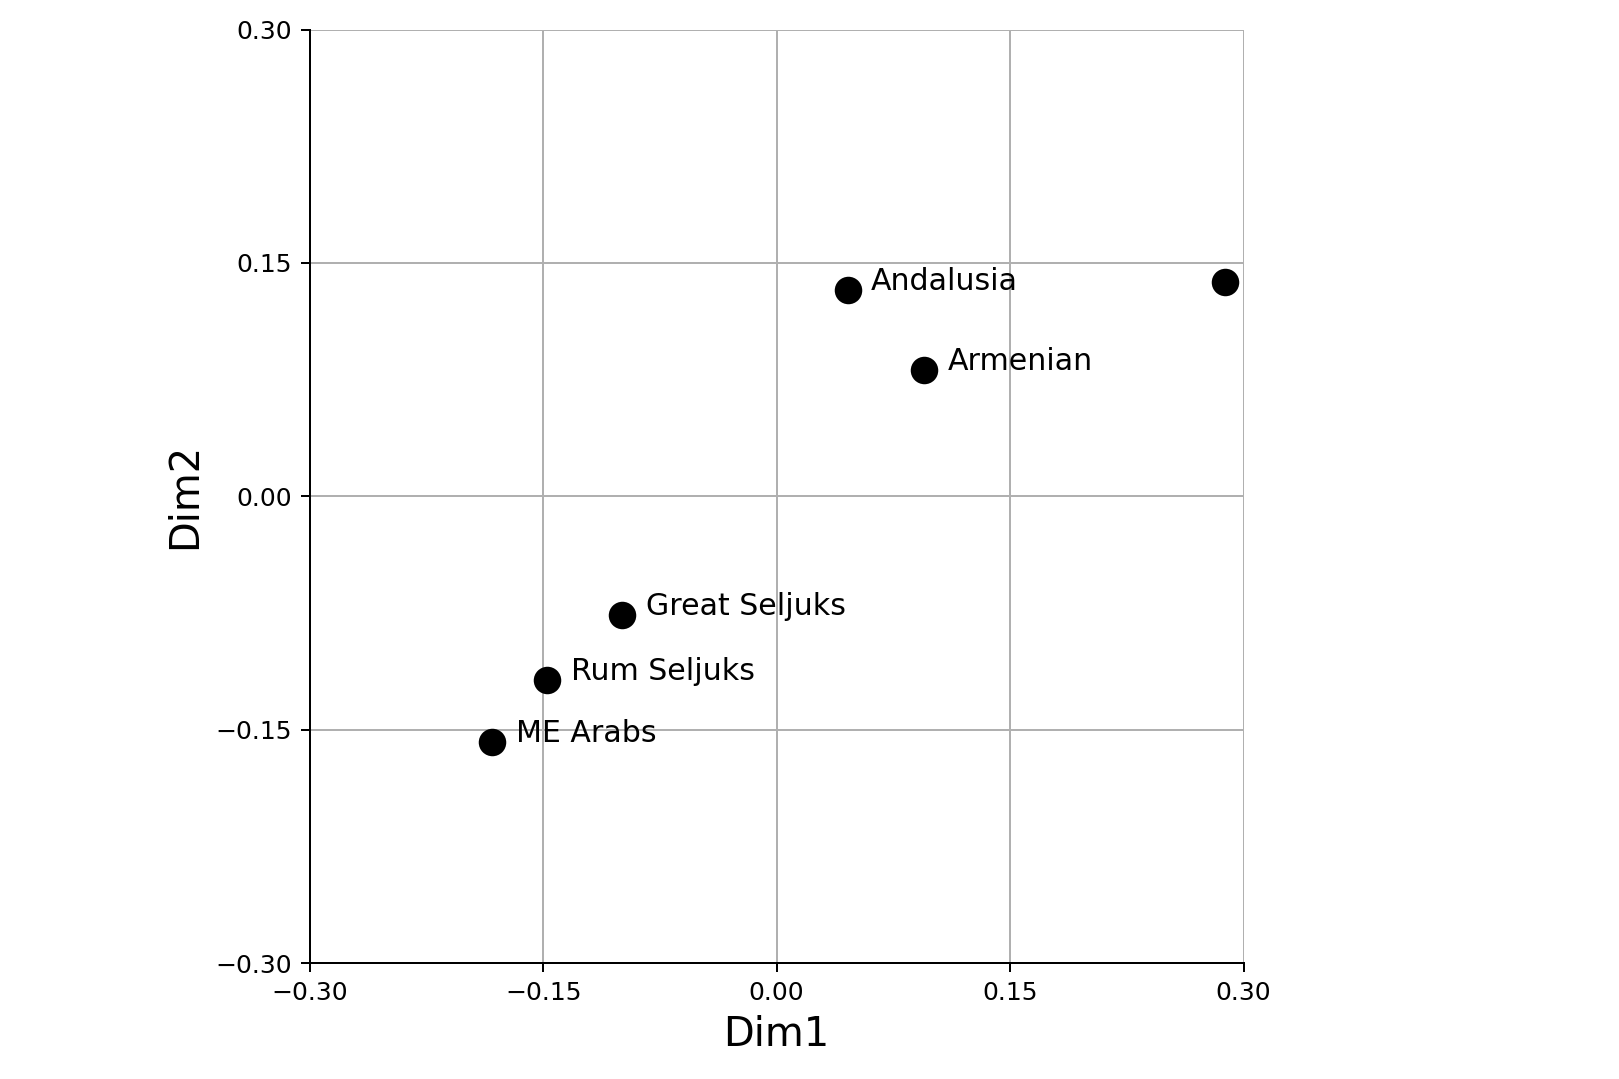

In [20]:
fig = plt.figure(figsize=(9,6))
ax  = fig.subplots(1,1)
ax  = plot_mds(symm_df,ax,xlim=0.3,ylim=0.3)

# Religious Proximity Matrix

<IPython.core.display.Javascript object>


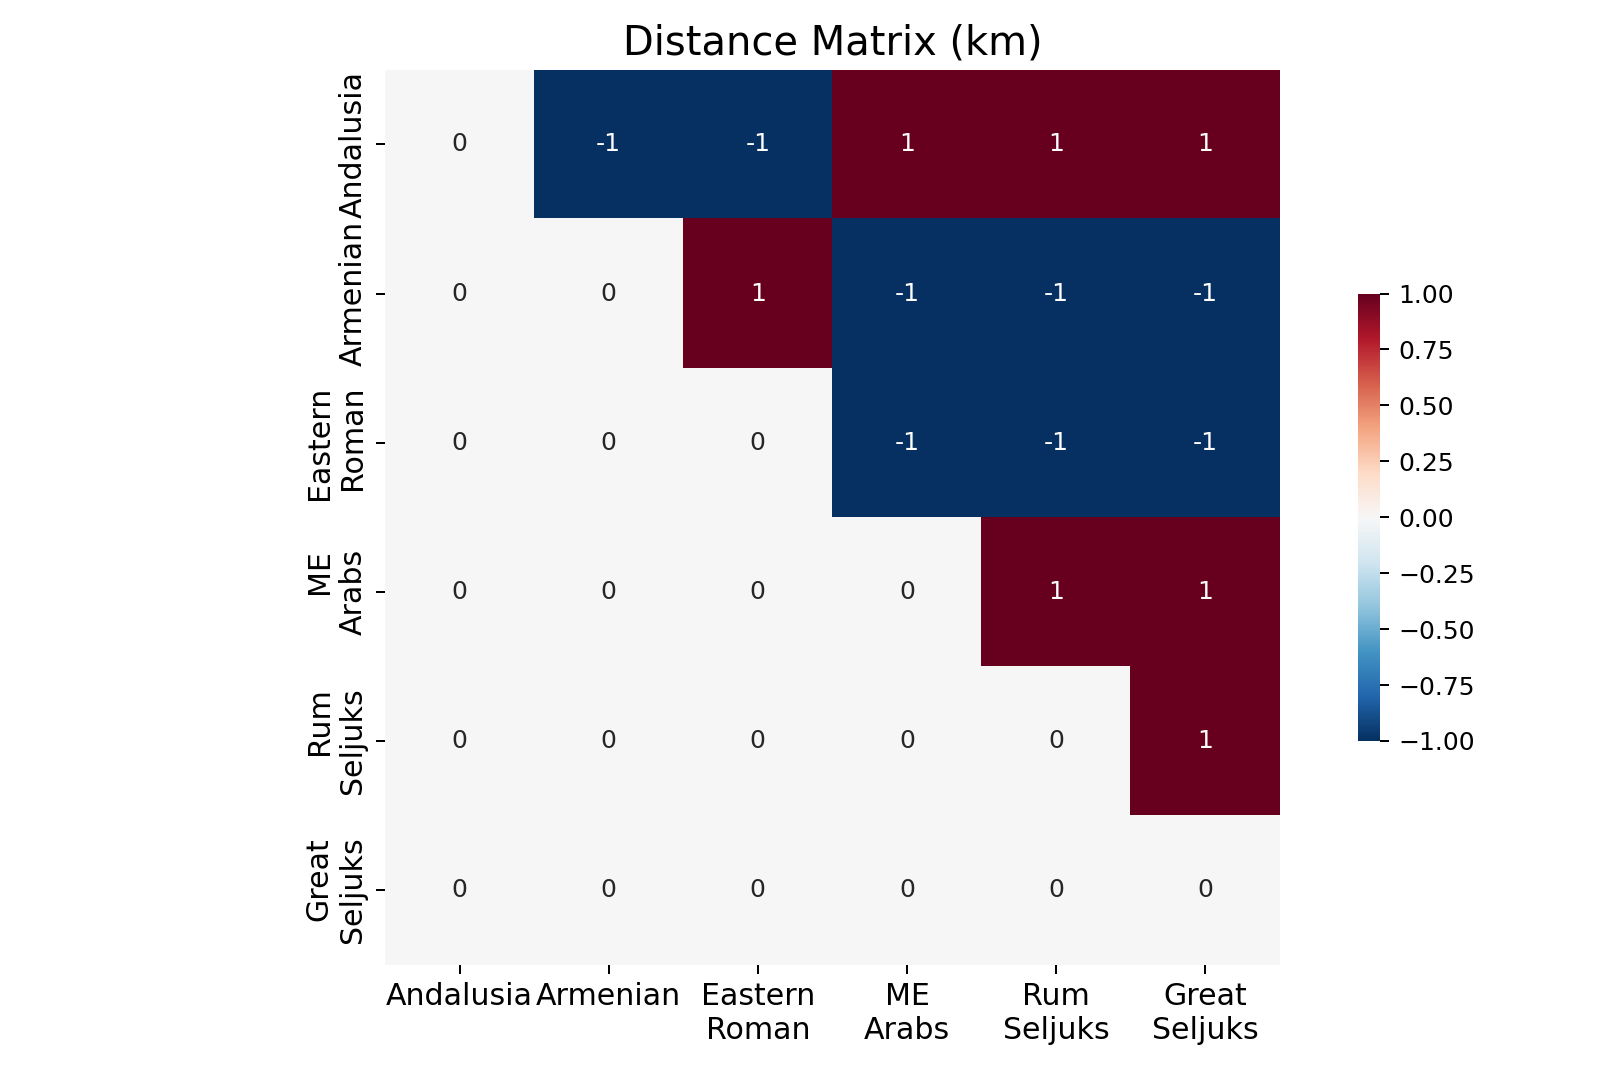

In [21]:
# Religious similarity matrix
Religion      = [-1,1,1,-1,-1,-1]
dist_religion = np.outer(Religion,Religion)
dist_religion = np.triu(dist_religion,1)

dist_religion = pd.DataFrame(dist_religion,columns=symm_df.columns,index=symm_df.columns)
fig = plt.figure(figsize=(9,6))
ax  = fig.subplots(1,1)
correlation_panel(dist_religion,ax,input_is_corr=True,TITLE='Distance Matrix (km)')


# Linear Regression

## We are asking the question of how to explain the similarity matrix of symmetries shown in 3.1. As potential explanatory variables, we use geographic proximity matrix as well as religious proximity matrix.

<IPython.core.display.Javascript object>


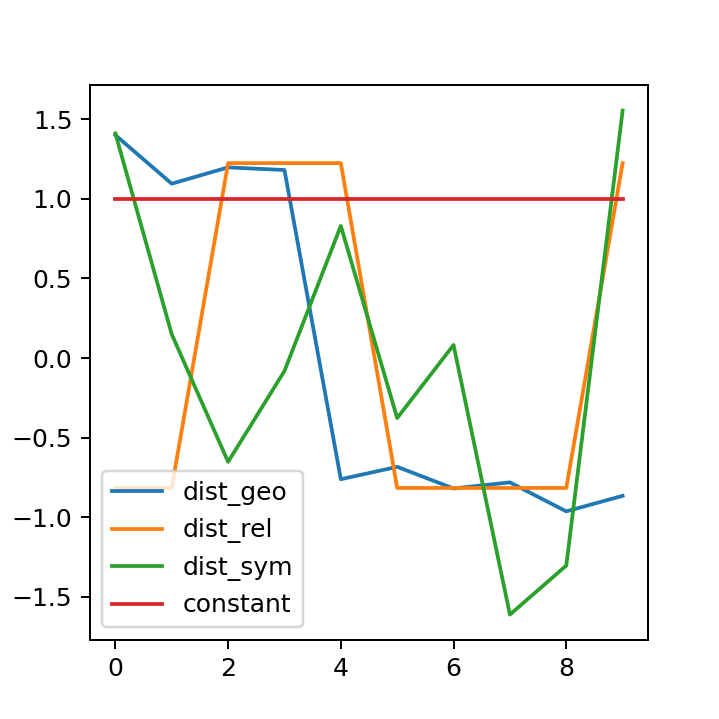

<AxesSubplot:>

In [23]:
sim             = pd.DataFrame()

i               = np.triu_indices(5,k=1)
sim["dist_geo"] = dist_geo.values[i]
sim["dist_rel"] = dist_religion.values[i]
sim["dist_sym"] = dist_symm.values[i]

sim =  sim.apply(zscore)
sim["constant"] = 1
fig,ax = plt.subplots(1,1,figsize=(4,4))
sim.plot(ax=ax)

In [24]:
import statsmodels.api as sm

X = sim[['dist_geo','dist_rel','constant']]
y = sim["dist_sym"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

/Users/sonat/Documents/repos/ornament_symmgroups/.env/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               dist_sym   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                 -0.111
Method:                 Least Squares   F-statistic:                    0.5498
Date:                Sun, 26 Jul 2020   Prob (F-statistic):              0.600
Time:                        11:59:50   Log-Likelihood:                -13.460
No. Observations:                  10   AIC:                             32.92
Df Residuals:                       7   BIC:                             33.83
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dist_geo       0.1509      0.356      0.424      0.684      -0.690       0.992
dist_rel       0.3138      0.356      0.882      0.407      -0.527       1.155
constant   -3.331e-16      0.351  -9.48e-16      1.000      -0.831       0.831
==============================================================================
Omnibus:                        1.252   Durbin-Watson:                   1.597
Prob(Omnibus):                  0.535   Jarque-Bera (JB):                0.697
Skew:                           0.109   Prob(JB):                        0.706
Kurtosis:                       1.725   Cond. No.                         1.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## The linear modelling does not return any significant contribution of neither geographic nor religious proximity.

I continue with the computation of correlations

In [25]:
sim.iloc[:,:3].corr()

,dist_geo,dist_rel,dist_sym
dist_geo,1.000000,0.153469,0.199050
dist_rel,0.153469,1.000000,0.336943
dist_sym,0.199050,0.336943,1.000000


<IPython.core.display.Javascript object>


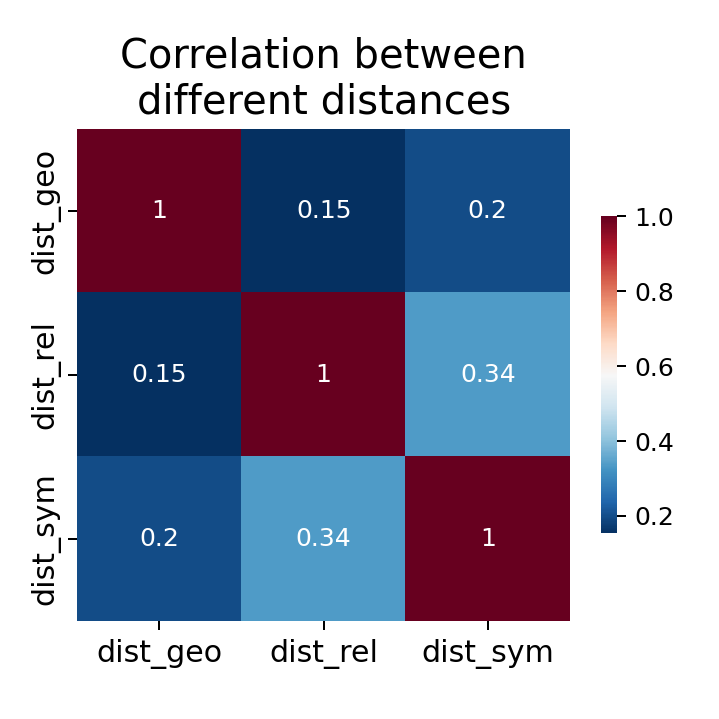

In [26]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
correlation_panel(sim.iloc[:,:3].corr(),
                  ax,
                  input_is_corr=True,
                  TITLE='Correlation between\ndifferent distances')

# Haritalar

In [27]:
df = pd.read_excel("./GeoList.xlsx",index_col=None,header=1)
df = df.reset_index(drop=True)
df = df.iloc[:,:5]
df.head(3)

,Andalusia Arabs,ME Arabs,Eastern Roman,Armenian,Seljuks
0,Cordoba,Bagdat,Venice,Yerevan,"Birgi, Turkey"
1,Granada,Cairo,NaN,NaN,"Akhan, Turkey"
2,Sevilla,Damascus,NaN,NaN,"Egridir, Turkey"


In [28]:
@memory.cache
def name_to_coor(name):
    if name is np.nan:
        lat,lon = (None,None)
        return lat,lon
    geolocator = Nominatim(user_agent="bla",timeout=10)
    location = geolocator.geocode(name)
    if not location is None:
        lat,lon = location.latitude,location.longitude
    else:
        lat,lon = None,None
    return lat,lon

for colname in ["Seljuks","Eastern Roman","ME Arabs", "Armenian","Andalusia Arabs"]:
    print(colname)
    df[colname + "_coor_lat"],df[colname + "_coor_long"] = zip(*df[colname].apply(name_to_coor))

df.head(4)

Seljuks
Eastern Roman
ME Arabs
Armenian
Andalusia Arabs


,Andalusia Arabs,ME Arabs,Eastern Roman,Armenian,Seljuks,Seljuks_coor_lat,Seljuks_coor_long,Eastern Roman_coor_lat,Eastern Roman_coor_long,ME Arabs_coor_lat,ME Arabs_coor_long,Armenian_coor_lat,Armenian_coor_long,Andalusia Arabs_coor_lat,Andalusia Arabs_coor_long
0,Cordoba,Bagdat,Venice,Yerevan,"Birgi, Turkey",38.2546,28.0654,45.4372,12.3346,33.3024,44.3788,40.1776,44.5126,37.8846,-4.77601
1,Granada,Cairo,NaN,NaN,"Akhan, Turkey",37.8137,29.1425,None,None,30.0488,31.2437,None,None,12.136,-61.6904
2,Sevilla,Damascus,NaN,NaN,"Egridir, Turkey",37.8741,30.849,None,None,33.5131,36.3096,None,None,37.3886,-5.99534
3,Valencia,Aleppo,NaN,NaN,"Incir han, Turkey",37.4788,30.5333,None,None,36.1992,37.1637,None,None,39.4697,-0.376335


In [139]:
#create a map
center_lat = df["Seljuks_coor_lat"].median()
center_lon = df["Seljuks_coor_long"].median()
this_map = folium.Map(prefer_canvas=True,location=[center_lat,center_lon],zoom_start = 3)
folium.TileLayer('stamenwatercolor').add_to(this_map)

def plotDot(lat,lon,color):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    
    for lat_,lon_ in zip(lat,lon):
        if not lat_ is None:
            folium.CircleMarker(location=[lat_,lon_],
                            radius=7,
                            weight=2,
                            color=color,
                            fill=True).add_to(this_map)

#use df.apply(,axis=1) to "iterate" through every row in your dataframe
plotDot(df["Seljuks_coor_lat"],df["Seljuks_coor_long"],color='red')
plotDot(df["Eastern Roman_coor_lat"],df["Eastern Roman_coor_long"],color='black')
plotDot(df["Armenian_coor_lat"],df["Armenian_coor_long"],color='green')
plotDot(df["ME Arabs_coor_lat"],df["ME Arabs_coor_long"],color='blue')
plotDot(df["Andalusia Arabs_coor_lat"],df["Andalusia Arabs_coor_long"],color='yellow')


this_map

# Time Diagram

In [29]:
next = 50
thick = 30
df = pd.DataFrame.from_dict({"Armenia" : [0,800,0+thick,1200],
                             "Seljuks":[0+next,1200,0+next+thick,1500],
                             "Eastern Roman" : [0+next*2,800,0+next*2+thick,1500],
                             "Moslem Arabs": [0+next*3,900,0+next*3+thick,1200]})
df

,Armenia,Seljuks,Eastern Roman,Moslem Arabs
0,0,50,100,150
1,800,1200,800,900
2,30,80,130,180
3,1200,1500,1500,1200


<IPython.core.display.Javascript object>


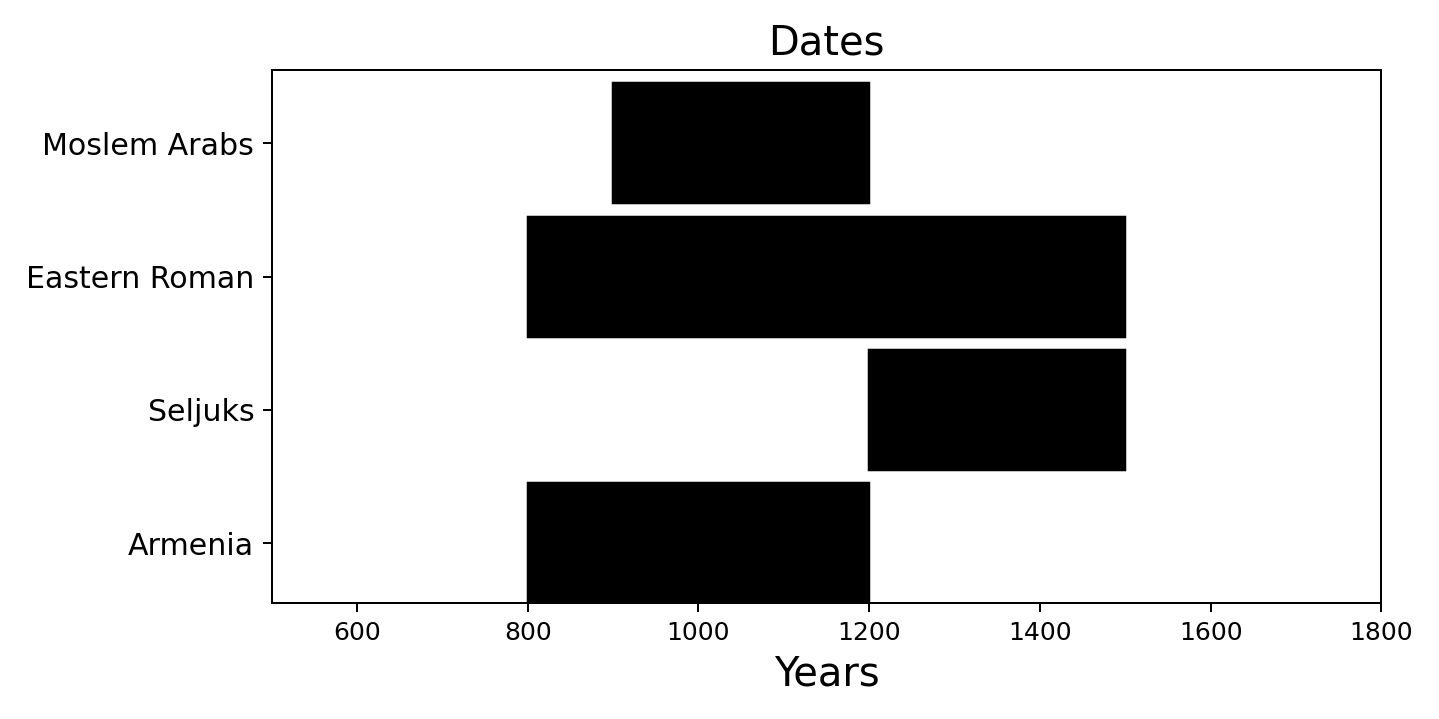

[   0  800   30 1200]
[  50 1200   80 1500]
[ 100  800  130 1500]
[ 150  900  180 1200]


In [296]:
import matplotlib.patches as patches
fig,ax = plt.subplots(1,figsize=(8,4))
# Create a Rectangle patch
for cols in df.columns:
    val = df[cols].values
    print(val)
    rect = patches.Rectangle((val[1],val[0]),val[3]-val[1],45,linewidth=1,edgecolor='k',facecolor='k')
    ax.add_patch(rect)


plt.show()
# plt.tight_layout()
ax.set_xlim(500,1800)
ax.set_ylim(0,200)
ax.set_yticks(np.array([0,50,100,150])+22.5)
ax.set_yticklabels(df.columns,fontsize=12)
ax.set_xlabel('Years',fontsize=16)
ax.set_title('Dates',fontsize=16)
plt.tight_layout()
